In [179]:
import os
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy
from scipy.stats import entropy
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit

In [180]:
set1 = pd.read_csv("./set1_timefeatures.csv")
set1 = set1.rename(columns={'Unnamed: 0':'time'})
#set1 = set1.set_index('time')
last_cycle = int(len(set1))

In [181]:
features = set1.copy()
#simple moving average SMA
ma = pd.DataFrame()
ma['B4_a_mean'] = features['B4_a_mean']
ma['SMA'] = ma['B4_a_mean'].rolling(window=5).mean()
ma['time'] = features['time']

In [182]:
ma['CMA'] = ma["B4_a_mean"].expanding(min_periods=10).mean()

In [183]:
ma['EMA'] = ma['B4_a_mean'].ewm(span=40,adjust=False).mean()

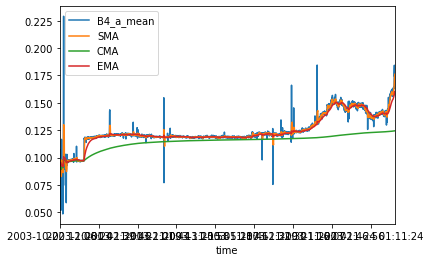

In [184]:
ma.plot(x="time", y= ['B4_a_mean','SMA','CMA','EMA'])

In [185]:
def health_indicator(bearing_data,use_filter=False):    
    data = bearing_data.copy()
    if use_filter:
        for ft in data.columns:
            data[ft] = data[ft].ewm(span=40,adjust=False).mean()
    pca = PCA()
    X_pca = pca.fit_transform(data)
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    print("Explained variance of Pricincipal Component 1 is:"+str(pca.explained_variance_ratio_[0]))
    health_indicator = np.array(X_pca['PC1'])
    degredation = pd.DataFrame(health_indicator,columns=['PC1'])
    degredation['cycle'] = degredation.index
    degredation['PC1'] = degredation['PC1']-degredation['PC1'].min(axis=0)
    
    return degredation

def fit_exp(df,base=500,print_parameters=False):
    x =np.array(df.cycle)
    x = x[-base:].copy()
    y = np.array(degredation.PC1)
    y = y[-base:].copy()
    def exp_fit(x,a,b):
        y = a*np.exp(abs(b)*x)
        return y
    #initial parameters affect the result
    fit = curve_fit(exp_fit,x,y,p0=[0.01,0.001],maxfev=10000)
    if print_parameters:
        print(fit)
    return fit

def predict(X_df,p):
    x =np.array(X_df.cycle)
    a,b = p[0]
    fit_eq = a*np.exp(abs(b)*x)
    return fit_eq
log = [[],[]]

In [186]:
#variable for incrementing index
prediction_cycle = 600
#variable for keeping intial value
init_cycle = prediction_cycle

In [187]:
selected_features = ['max','p2p','rms']

bearing = 3
B_a = ["B{}_a_".format(bearing)+i for i in selected_features]
early_cycles = set1[B_a][:init_cycle]
early_cycles_pca = health_indicator(early_cycles,use_filter=True)

Explained variance of Pricincipal Component 1 is:0.9955862512721826


Explained variance of Pricincipal Component 1 is:0.9955862512721826
Explained variance of Pricincipal Component 1 is:0.9956274322666577
Explained variance of Pricincipal Component 1 is:0.994738878585239
Explained variance of Pricincipal Component 1 is:0.9944323438515958
Explained variance of Pricincipal Component 1 is:0.9945131999470982
Explained variance of Pricincipal Component 1 is:0.9943348936040264
Explained variance of Pricincipal Component 1 is:0.994065675149865
Explained variance of Pricincipal Component 1 is:0.9941425509350195
Explained variance of Pricincipal Component 1 is:0.9942258600849837
Explained variance of Pricincipal Component 1 is:0.994318212879631
Explained variance of Pricincipal Component 1 is:0.9944246593499706
Explained variance of Pricincipal Component 1 is:0.994553591035802
Explained variance of Pricincipal Component 1 is:0.9946231419277928
Explained variance of Pricincipal Component 1 is:0.9948198478976993
Explained variance of Pricincipal Component 1 is:0.9

C:\Users\SWIFT 3\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Explained variance of Pricincipal Component 1 is:0.9963388319181669
Explained variance of Pricincipal Component 1 is:0.9963345115234453
Explained variance of Pricincipal Component 1 is:0.9964219658348753
Explained variance of Pricincipal Component 1 is:0.9958652850773464
Explained variance of Pricincipal Component 1 is:0.9975708909365656
Explained variance of Pricincipal Component 1 is:0.9984235244672488
Explained variance of Pricincipal Component 1 is:0.9988442271438023
Explained variance of Pricincipal Component 1 is:0.9989920656412192
Explained variance of Pricincipal Component 1 is:0.9990413747503314
Explained variance of Pricincipal Component 1 is:0.9990896642794795
Explained variance of Pricincipal Component 1 is:0.999224376817439
Explained variance of Pricincipal Component 1 is:0.9993672946748798
Explained variance of Pricincipal Component 1 is:0.9994473749768741
Explained variance of Pricincipal Component 1 is:0.999440766843761
Explained variance of Pricincipal Component 1 is:0

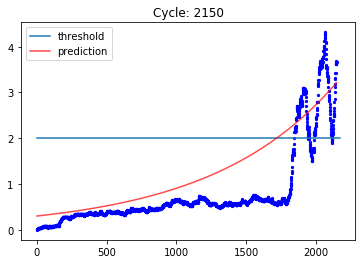

In [188]:
while prediction_cycle <=2150:
    data = set1[B_a][:prediction_cycle]
    ind=data.index
    degredation = health_indicator(data,use_filter=True)
    #degredation.plot(y='PC1',x='cycle')
    fit = fit_exp(degredation,base=250)

    prediction = predict(degredation,fit)
    m,n = fit[0]
    thres = 2
    #print(prediction_cycle)
    fail_cycle = (np.log(thres/m))/abs(n)
    log[0].append(prediction_cycle)
    log[1].append(fail_cycle)
    
    increment_cycle = 25
    prediction_cycle = prediction_cycle + increment_cycle
    

print(m,n)
print('failed at'+str(fail_cycle))

fig =plt.figure('Cycle: '+str(prediction_cycle))
ax =fig.subplots()

ax.plot([0,prediction_cycle],[2,2])
ax.scatter(degredation['cycle'],degredation['PC1'],color='b',s=5)
ax.plot(degredation['cycle'],prediction,color='r',alpha=0.7)
ax.set_title('Cycle: '+str(prediction_cycle-increment_cycle))
ax.legend(['threshold','prediction'])
fig.savefig('output.png')
plt.show()

In [189]:
d = {'time':set1['time'][init_cycle::increment_cycle],'cycle': log[0], 'prediction': (np.array(log[1]))}
df = pd.DataFrame(data=d)
df['isvalid'] = df['prediction']<2156
#adding real labels for analysing results
df['real'] = np.zeros(len(set1['time'][init_cycle::increment_cycle]))

for row in set1['time'][init_cycle::increment_cycle].index:
    if bearing == 1:
        if row<=151:
            df['real'][row] = 'early'
        if 151 < row <=600:
            df['real'][row] = "suspect"
        if 600 < row <=1499:
            df['real'][row] = "normal"
        if 1499 < row <=2098:
            df['real'][row] = "suspect"
        if 2098 < row <= 2156:
            df['real'][row] =("imminent_failure")
    if bearing == 2:
        if row<=500:
            df['real'][row] =("early")
        if 500 < row <=2000:
            df['real'][row] =("normal")
        if 2000 < row <=2120:
            df['real'][row] =("suspect")
        if 2120< row <=2156:
            df['real'][row] =("imminet_failure")

    if bearing == 3:
        if row<=500:
            df['real'][row] =("early")
        if 500 < row <= 1790:
            df['real'][row] =("normal")
        if 1790 < row <=2120:
            df['real'][row] =("suspect")
        if 2120 < row <=2156:
            df['real'][row] =("Inner_race_failure")
    if bearing == 4:
        if row<=200:
            df['real'][row] =("early")
        if 200 < row <=1000:
            df['real'][row] =("normal")
        if 1000 < row <= 1435:
            df['real'][row] =("suspect")
        if 1435 < row <=1840:
            df['real'][row] =("Inner_race_failure")
        if 1840 < row <=2156:
            df['real'][row] =("Stage_two_failure")

print(bearing)
print(df.tail(60))

3
                     time  cycle    prediction  isvalid                real
675   2003-11-09 00:51:44    675  6.297547e+11    False              normal
700   2003-11-09 05:01:44    700  2.441019e+11    False              normal
725   2003-11-09 09:05:58    725  6.174790e+10    False              normal
750   2003-11-09 13:15:58    750  1.383210e+11    False              normal
775   2003-11-09 17:25:58    775  1.072897e+11    False              normal
800   2003-11-10 01:05:58    800  8.676708e+10    False              normal
825   2003-11-10 05:15:58    825  2.411621e+11    False              normal
850   2003-11-10 09:25:58    850  1.559996e+12    False              normal
875   2003-11-10 13:35:58    875  3.188454e+11    False              normal
900   2003-11-14 12:12:17    900  6.552460e+10    False              normal
925   2003-11-14 16:22:17    925  4.651596e+10    False              normal
950   2003-11-14 20:58:46    950  4.669479e+11    False              normal
975   2003

C:\Users\SWIFT 3\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\SWIFT 3\Anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\SWIFT 3\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\SWIFT 3\Anaconda3\lib\site-packages\ipyk

In [190]:
set2 = pd.read_csv("./set2_timefeatures.csv")
set2 = set2.rename(columns={'Unnamed: 0':'time'})
set2.head()

,time,B1_mean,B1_std,B1_skew,B1_kurtosis,B1_entropy,B1_rms,B1_max,B1_p2p,B1_crest,...,B4_skew,B4_kurtosis,B4_entropy,B4_rms,B4_max,B4_p2p,B4_crest,B4_clearence,B4_shape,B4_impulse
0,2004-02-12 10:32:39,0.058333,0.073478,0.083929,0.629118,4.811406,0.074180,0.454,0.840,6.120246,...,-0.022081,0.066118,4.494251,0.054105,0.264,0.457,4.879424,0.036259,1.256305,6.130047
1,2004-02-12 10:42:39,0.058995,0.075339,0.052054,0.648930,4.835310,0.075382,0.388,0.757,5.147132,...,0.001645,0.107769,4.545837,0.056102,0.249,0.478,4.438343,0.037465,1.259558,5.590350
2,2004-02-12 10:52:39,0.060236,0.076189,0.032869,0.514258,4.848343,0.076228,0.503,0.903,6.598658,...,0.070516,0.257503,4.544783,0.056146,0.354,0.688,6.304948,0.037331,1.263332,7.965243
3,2004-02-12 11:02:39,0.061455,0.078694,0.041523,1.158352,4.761551,0.078726,0.608,1.184,7.723037,...,-0.036409,0.806635,4.553737,0.056808,0.525,1.038,9.241630,0.037989,1.260124,11.645601
4,2004-02-12 11:12:39,0.061361,0.078440,0.028134,0.603647,4.875062,0.078475,0.391,0.782,4.982488,...,0.019103,0.139316,4.560105,0.056841,0.244,0.456,4.292638,0.037949,1.259831,5.407997


In [191]:
log = [[],[]]
#variable for incrementing index
prediction_cycle = 550
#variable for keeping intial value
init_cycle = prediction_cycle

In [192]:
selected_features = ['max','p2p']
bearing = 1
B_a = ["B{}_".format(bearing)+i for i in selected_features]
early_cycles = set2[B_a][:init_cycle]
early_cycles_pca = health_indicator(early_cycles,use_filter=True)

Explained variance of Pricincipal Component 1 is:0.9884828972761082


Explained variance of Pricincipal Component 1 is:0.9884828972761082
Explained variance of Pricincipal Component 1 is:0.99100671575026
Explained variance of Pricincipal Component 1 is:0.9936308154438782
Explained variance of Pricincipal Component 1 is:0.9957428963986522
Explained variance of Pricincipal Component 1 is:0.9970955082097809
Explained variance of Pricincipal Component 1 is:0.9980295585814309
Explained variance of Pricincipal Component 1 is:0.9985127353677516
Explained variance of Pricincipal Component 1 is:0.9994907110554705
Explained variance of Pricincipal Component 1 is:0.999770015538011
Explained variance of Pricincipal Component 1 is:0.999821117062107
Explained variance of Pricincipal Component 1 is:0.9998324444457378
Explained variance of Pricincipal Component 1 is:0.9998273607160061
Explained variance of Pricincipal Component 1 is:0.9998441232179017
Explained variance of Pricincipal Component 1 is:0.9998624884084318
Explained variance of Pricincipal Component 1 is:0.9

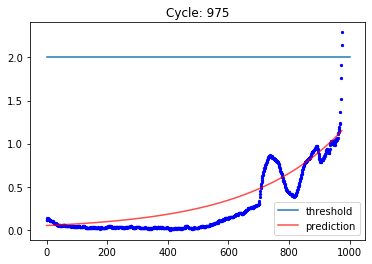

In [193]:
while prediction_cycle <=975:
    data = set2[B_a][:prediction_cycle]
    ind=data.index
    degredation = health_indicator(data,use_filter=True)
    #degredation.plot(y='PC1',x='cycle')
    fit = fit_exp(degredation,base=250)

    prediction = predict(degredation,fit)
    m,n = fit[0]
    thres = 2
    #print(prediction_cycle)
    fail_cycle = (np.log(thres/m))/abs(n)
    log[0].append(prediction_cycle)
    log[1].append(fail_cycle)
    
    increment_cycle = 25
    prediction_cycle = prediction_cycle + increment_cycle
    

print(m,n)
print('failed at'+str(fail_cycle))

fig =plt.figure('Cycle: '+str(prediction_cycle))
ax =fig.subplots()

ax.plot([0,prediction_cycle],[2,2])
ax.scatter(degredation['cycle'],degredation['PC1'],color='b',s=5)
ax.plot(degredation['cycle'],prediction,color='r',alpha=0.7)
ax.set_title('Cycle: '+str(prediction_cycle-increment_cycle))
ax.legend(['threshold','prediction'])
fig.savefig('output.png')
plt.show()

In [194]:
d = {'time':set2['time'][init_cycle::increment_cycle],'cycle': log[0], 'prediction': (np.array(log[1]))}
df = pd.DataFrame(data=d)
df['is valid'] = df['prediction']<984
df.head(30)

,time,cycle,prediction,is valid
550,2004-02-16 06:12:39,550,1402.670071,False
575,2004-02-16 10:22:39,575,869.128385,True
600,2004-02-16 14:32:39,600,794.876152,True
625,2004-02-16 18:42:39,625,808.617636,True
650,2004-02-16 22:52:39,650,833.999476,True
675,2004-02-17 03:02:39,675,855.337128,True
700,2004-02-17 07:12:39,700,884.550218,True
725,2004-02-17 11:22:39,725,799.891633,True
750,2004-02-17 15:32:39,750,796.115972,True
775,2004-02-17 19:42:39,775,837.240929,True
